In [1]:
import json

def get_cycles_count(prof_dict):
    """Loops over a dict that has the profiling of a code (the occurrence of each instruction).

The dict has the form: { <instruction>: #count,....}. Instructions are add, mul, sub, etc.

This function returns the total number of instructions for the profiled code."""
    
    cycles = 0
    for k, v in prof_dict.items():
        cycles += v

    return cycles

def time_estimate(cycles_count, cpu_freq= 20e6, unit='us'):
    """This function takes as an input the total number of instructions executed and multiplies it by the time of a single cycle to get the
        total execution time.

        It is considered that each instruction takes one cycle, and the hazards and events of the pipeline are being ignored for simplicity.

        The time for a single cycle depends on the clock frequency of the CPU (in Hz), which defaults to 20 MHz.

        Returned value precision can be adjusted using the unit parameter, which defaults to microseconds.

        Valid options for the unit parameter are: s, ms, us, and ns."""

    if unit == "us":
        t_cycle = 1e6/cpu_freq
    elif unit == "s":
        t_cycle = 1/cpu_freq
    elif unit == "ms":
        t_cycle = 1e3/cpu_freq
    elif unit == "ns":
        t_cycle = 1e9/cpu_freq

    return cycles_count*t_cycle

def get_all_cycles_profile(file_path): # estimation using profiled data
    """This function takes as a parameter the path of a JSON file containing the profiling of multiple benchmarks.
        It will read the file, loop over all benchmarks to apply the 'get_cycles_count' function, and then store the result in a dict.
        The returned value will be a dict as follows: { <benchmark_1> : #Nb_cycles, <benchmark_2> : #Nb_cycles, ...}"""
    
    cycles_dict = {}
    with open(file_path, 'r') as file:
        data = json.load(file)
        for k, v in data.items():
            cycles_dict[k] = get_cycles_count(v)

    return cycles_dict


def get_all_cycles_data(file_path): # True measurements
    """This function takes as a parameter the path of a JSON file containing the true measurements of each benchmark. 
    The JSON has the following form: {<benchmark_1>: {power: #power, cycles: #cycles}}. 
    In this case, the number of cycles is already calculated in the benchmark measurements by subtracting the end_time from the start_time 
    (start_time: when the trigger is set to HIGH, end_time: when the trigger is cleared to LOW)."""
    
    cycles_dict = {}
    with open(file_path, 'r') as file:
        data = json.load(file)
        for k, v in data.items():
            cycles_dict[k] = v['cycles']

    return cycles_dict

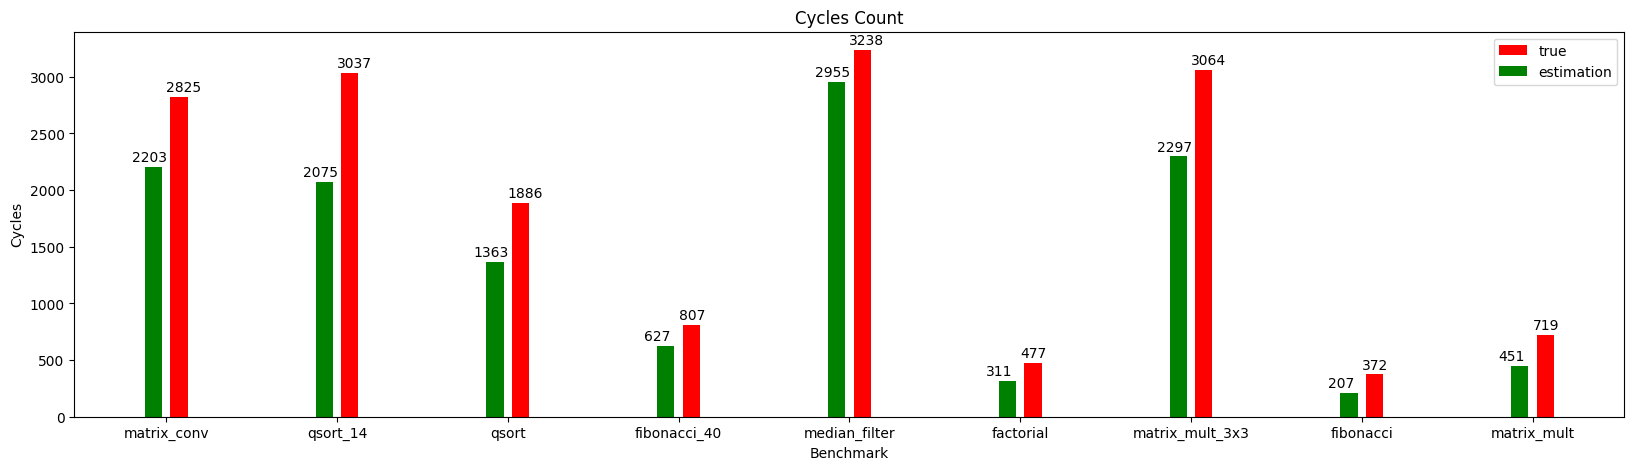

In [9]:
import matplotlib.pyplot as plt
import numpy as np

true_cycles_dict = get_all_cycles_data('results/benchmarks_data.json') 
profile_cycles_dict = get_all_cycles_profile('results/benchmarks_profile.json')

b_regex = {
 'matrix_conv': 'matrix_conv_50MHz', 
 'qsort_14': 'qsort_50MHz_14',
  'qsort': 'qsort_50MHz',
  'fibonacci_40': 'fibonacci_100MHz_40',
  'median_filter': 'median_filter_50MHz',
  'factorial': 'Factorial_100MHz',
  'matrix_mult_3x3': 'matrix_mult_50MHz_3x3',
  'fibonacci': 'fibonacci_100MHz',
  'matrix_mult': 'matrix_mult_100MHz'}

x = np.arange(len(profile_cycles_dict))

w = 0.15
width = 0.1

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.bar(x+w/2, [true_cycles_dict[b_regex[k]] for k in profile_cycles_dict.keys()], width=width, color='r', align='center', label='true')
ax.bar(x-w/2, [profile_cycles_dict[k] for k in profile_cycles_dict.keys()], width=width, color='g', align='center', label='estimation')


for i, v in enumerate([true_cycles_dict[b_regex[k]] for k in profile_cycles_dict.keys()]):
    plt.text(i, v+50, str(v))

for i, v in enumerate([profile_cycles_dict[k] for k in profile_cycles_dict.keys()]):
    plt.text(i-0.2, v+50, str(v))

plt.title('Cycles Count')
plt.xticks(x, profile_cycles_dict.keys())
plt.xlabel('Benchmark')
plt.ylabel('Cycles')
plt.legend()

plt.show()

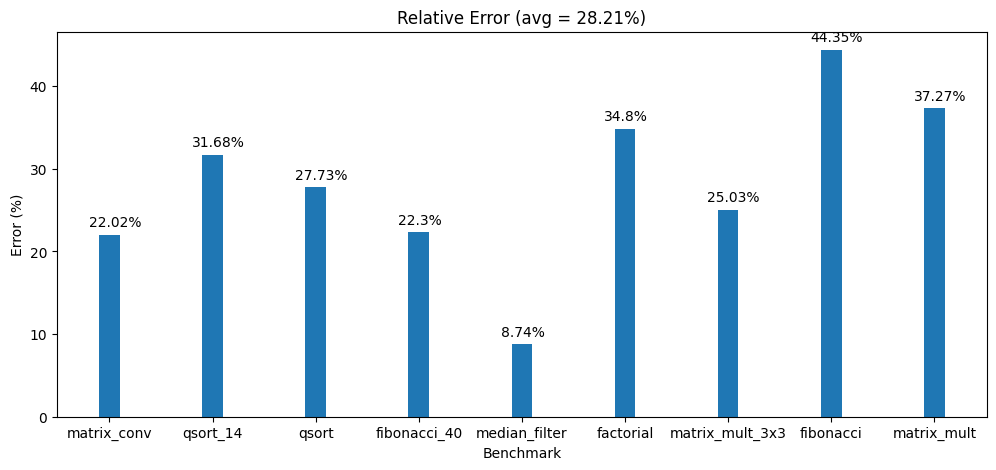

In [11]:
from statistics import mean
import matplotlib.pyplot as plt

# assert len(profile_cycles_dict) == len(true_cycles_dict)

relative_error_dict = {}
for k, v in profile_cycles_dict.items():
    relative_error_dict[k] = 100*abs(v-true_cycles_dict[b_regex[k]])/true_cycles_dict[b_regex[k]]

avg_rel_error = round(mean(relative_error_dict.values()), 2)
plt.figure(figsize=(12, 5))
plt.title(f"Relative Error (avg = {avg_rel_error}%)")
plt.bar(relative_error_dict.keys(), relative_error_dict.values(), width=0.2, align= 'center')
for i, v in enumerate(relative_error_dict.values()):
    plt.text(i-0.2, v+1, str(round(v, 2))+"%")
plt.xlabel("Benchmark")
plt.ylabel("Error (%)")
plt.show()